In [ ]:

import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AutoModelForSequenceClassification, AutoTokenizer, pipeline
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from afinn import Afinn
from tqdm import tqdm
import unidecode
from time import sleep
logging.basicConfig(level=logging.INFO)# OPTIONAL

In [ ]:
print(f"PyTorch version: {torch.__version__}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# Evaluators functions 
Hurtlex: https://github.com/valeriobasile/hurtlex

In [ ]:
def strip_accent(accented_string):
    return unidecode.unidecode(str(accented_string))


def HurtlexSetup():
    language = 'en'
    #assert language in ['it', 'fr', 'es', 'pt', 'ro', 'en']
    hurtlex = pd.read_csv(f"https://raw.githubusercontent.com/MilaNLProc/hurtlex/master/lexica/{language.upper()}/1.2/hurtlex_{language.upper()}.tsv", sep="\t")
    hurtlex = hurtlex[hurtlex["level"] == "conservative"]
    hurtlex["lemma"] = hurtlex["lemma"].apply(strip_accent)
    #categories = set(self.hurtlex["category"].unique())
    #words = set(self.hurtlex["lemma"].unique())
    return hurtlex

def get_hurtlex_category(hurtlex, lemma):
    try:
        return hurtlex[hurtlex["lemma"] == strip_accent(lemma)]["category"].values[0]
    except:
        return ''

def SentimentAnalysis(afn, word):
    return afn.score(word)

def _sum(arr):
    sum = 0
    for i in arr:
        sum = sum + i
    return(sum)
    
def Classifier_SD():
    model = AutoModelForSequenceClassification.from_pretrained('NLP-LTU/bertweet-large-sexism-detector')
    tokenizer = AutoTokenizer.from_pretrained('NLP-LTU/bertweet-large-sexism-detector') 
    classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    return classifier

def SexismDetectorEvaluator(classifier ,sentence):
    prediction=classifier(sentence)
    #print(sentence)
    #print(prediction[0]['label'])
    if(prediction[0]['label'] == "sexist"):
        return 1, prediction[0]['score']
    else: 
        return 0, prediction[0]['score']


# Evaluation algorithm

In [ ]:
class OpenPrediction():
    def __init__(self, template_file, target_file, model_name, numAtt):
        self.template_file = template_file
        self.target_file = target_file
        self.numAtt = numAtt
        self.data = []
        self.model_name = model_name
        self.model = BertForMaskedLM.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model.eval()
        self.createTemplate()

    def createTemplate(self):
        mask = "[MASK]"
        target = '<target>'
        s='______'
        gender = {'female':1, 'male':2} 
        dataList =[]
        #For each sentence in the template
        for index,row in tqdm(self.template_file.iterrows(), total=self.template_file.shape[0], desc='Creating template', unit='sentences'):
            sentence = row.loc['template']
            #For each target coherent with the template
            for ind, r in self.target_file.iterrows():
                if r.loc['target'] == row.loc['target']:
                        adjectiveList = []
                        #For both gender
                        for t in gender.keys():
                            _sentence = re.sub(target, r.loc[t], sentence)  
                            _sentence = re.sub(s, mask, _sentence) 
                            adjectiveList = self.predict_masked_sent(_sentence) 
                            sentencesNew = []
                            #detector_scores = []
                            for a in adjectiveList:
                                #print(f"{a}")
                                #print(f"{_sentence}")
                                comp_sentence = re.sub('\[MASK\]', a, _sentence)
                                #print(f"{comp_sentence}")
                                sentencesNew.append(comp_sentence)                                
                            data=[
                                sentence, #template
                                r.loc[t], #subject
                                adjectiveList, #word list
                                sentencesNew, #sentence list
                                #detector_scores #scores 
                            ]
                            dataList.append(data)
                            #print(dataList)
        data_df = pd.DataFrame(dataList, columns=["template", "target", "attributes", "sentences"])
        self.data = data_df
        #print(data_df)
        #return dataList

    #Given a number n and a sentence containing a [MASK], it generates the top n words that fits the MASK 
    def predict_masked_sent(self, text):
        # Tokenize input
        text = "[CLS] %s [SEP]"%text
        #print(f"text: {text}")
        tokenized_text = self.tokenizer.tokenize(text)
        masked_index = tokenized_text.index("[MASK]")
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens])
        # tokens_tensor = tokens_tensor.to('cuda')    # if you have gpu

        # Predict all tokens
        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = outputs[0]

        probs = torch.nn.functional.softmax(predictions[0, masked_index], dim=-1)
        top_k_weights, top_k_indices = torch.topk(probs, self.numAtt, sorted=True)

        adjectiveList =[]
        for i, pred_idx in enumerate(top_k_indices):
            predicted_token = self.tokenizer.convert_ids_to_tokens([pred_idx])[0]
            token_weight = top_k_weights[i]
            # adjective=[
            #     predicted_token,
            #     float(token_weight),
            # ]
            adjectiveList.append(predicted_token)
            #print("[MASK]: '%s'"%predicted_token, " | weights:", float(token_weight)*1000)
        return adjectiveList
    
    def evaluate_predictions(self):
        sexist_detector_label = []
        sexism_detector_count = []
        hurtlex = []
        sent_analysis = []
        afn = Afinn()
        classifier = Classifier_SD()
        hurtlex_evaluator = HurtlexSetup()
        for index,row in tqdm(self.data.iterrows(), total=self.data.shape[0], desc='Evaluating sentences', unit='sentences'):
            sleep(0.0001)
            adj_lbl = []
            sent_score = []
            for sent in row['sentences']:
                label, score = SexismDetectorEvaluator(classifier, sent)
                adj_lbl.append(label)
                sent_score.append(score)
            sexism_detector_count.append(_sum(adj_lbl))
            sexist_detector_label.append(adj_lbl)
            hurtlex_tmp = []
            sent_analysis_tmp = []
            for wrd in row['attributes']:
                    #print(wrd)
                    hurtlex_tmp.append(get_hurtlex_category(hurtlex_evaluator, wrd))
                    sent_analysis_tmp.append(SentimentAnalysis(afn, wrd))
            hurtlex.append(hurtlex_tmp)
            sent_analysis.append(sent_analysis_tmp)
        self.data.loc[:,'sexism detector'] = sexist_detector_label
        self.data.loc[:,'sexism detector count'] = sexism_detector_count
        self.data.loc[:,'hurtlex'] = hurtlex
        self.data.loc[:,'sentiment analysis'] = sent_analysis
        self.data.to_csv(f"../src/result/sexisminsocietal_{self.model_name}_results.csv", sep=";")
    
    def get_data(self):
        return self.data

# Utili per disegnare i grafici

In [ ]:
# PS	negative stereotypes ethnic slurs
# RCI	locations and demonyms
# PA	professions and occupations
# DDF	physical disabilities and diversity
# DDP	cognitive disabilities and diversity
# DMC	moral and behavioral defects
# IS	words related to social and economic disadvantage
# OR	plants
# AN	animals
# ASM	male genitalia
# ASF	female genitalia
# PR:	words related to prostitution
# OM:	words related to homosexuality
# QAS	with potential negative connotations
# CDS	derogatory words
# RE	felonies and words related to crime and immoral behavior
# SVP	words related to the seven deadly sins of the Christian tradition
categories = ['', 'ps', 'rci', 'pa', 'ddf', 'ddp', 'dmc', 'is', 'or', 'an', 'asm', 'asf', 'pr', 'om', 'qas', 'cds', 're', 'svp']

def hurtlex_converter(label):
    if label == categories[1]:
        return 1
    elif label == categories[2]:
        return 2
    elif label == categories[3]:
        return 3
    elif label == categories[4]:
        return 4  
    elif label == categories[5]:
        return 5
    elif label == categories[6]:
        return 6
    elif label == categories[7]:
        return 7
    elif label == categories[8]:
        return 8
    elif label == categories[9]:
        return 9
    elif label == categories[10]:
        return 10
    elif label == categories[11]:
        return 11
    elif label == categories[12]:
        return 12  
    elif label == categories[13]:
        return 13
    elif label == categories[14]:
        return 14
    elif label == categories[15]:
        return 15
    elif label == categories[16]:
        return 16
    elif label == categories[17]:
        return 17
    else:
        return 0

def sentiment_analisys_counter(val, array):
    if val == -5:
        array[0] = array[0] + 1
    elif val == -4:
        array[1] = array[1] + 1
    elif val == -3:
        array[2] = array[2] + 1
    elif val == -2:
        array[3] = array[3] + 1
    elif val == -1:
        array[4] = array[4] + 1
    elif val == 0:
        array[5] = array[5] + 1
    elif val == 1:
        array[6] = array[6] + 1
    elif val == 2:
        array[7] = array[7] + 1
    elif val == 3:
        array[8] = array[8] + 1
    elif val == 4:
        array[9] = array[9] + 1
    elif val == 5:
        array[10] = array[10] + 1
    return array

# Funzioni per la generazione dei grafici

In [ ]:
def hurtlex_graph(file, model_name):
    hurtlex_fem = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    hurtlex_mal = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for index,row in file.iterrows():
        sleep(0.0001)
        for lbl in row['hurtlex']:
            num = hurtlex_converter(lbl)
            if (index % 2) == 0: #female
                hurtlex_fem[num] = hurtlex_fem[num] + 1 
            else:
                hurtlex_mal[num] = hurtlex_mal[num] + 1
    hurtlex_fem.pop(0)
    hurtlex_mal.pop(0)
    X = ['ps', 'rci', 'pa', 'ddf', 'ddp', 'dmc', 'is', 'or', 'an', 'asm', 'asf', 'pr', 'om', 'qas', 'cds', 're', 'svp']
    Ygirls = hurtlex_fem
    Zboys = hurtlex_mal
    
    X_axis = np.arange(len(X))
    
    plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Female')
    plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Male')
    
    plt.xticks(X_axis, X, rotation=30)
    plt.xlabel("Hurtlex categories")
    plt.ylabel("Number of words categorized")
    plt.title(f"Sexism in Societal - {model_name}")
    plt.legend()
    name_file = "../src/graph/"+f"Sexism in Societal [hurtlex] - {model_name}.png"
    plt.savefig(name_file)
    plt.show()

def sentiment_graphs(file, model_name):
    avg_fem = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    avg_mal = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    i = 0
    for index,row in file.iterrows():
        for num in row['sentiment analysis']:
            if (index % 2) == 0: #female
                avg_fem = sentiment_analisys_counter(num, avg_fem)
            else:
                avg_mal = sentiment_analisys_counter(num, avg_mal)
  
    X = ["-5", "-4", "-3", "-2", "-1", "1", "2", "3", "4", "5"]
    avg_mal.pop(5)
    avg_fem.pop(5)
    print(avg_mal)
    print(avg_fem)
    print(X)
    Ygirls = avg_fem
    Zboys = avg_mal
    X_axis = np.arange(len(X))
    plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Female')
    plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Male')
    plt.xticks(X_axis, X)
    plt.xlabel("Sentiment analisys rating")
    plt.ylabel("Number of words categorized")
    plt.title(f"Sexism in Societal - {model_name}")
    plt.legend()
    name_file = "../src/graph/"+f"Sexism in Societal [sentiment analisys] - {model_name}.png"
    plt.savefig(name_file)
    plt.show()

def sexism_detector_counter(file, model_name):
    male = 0 
    female = 0
    i = 0
    for index,row in file.iterrows():
        i = index +1
        sleep(0.0001)
        lbl = row['sexism detector count']
        if (index % 2) == 0: #female
            female = female + lbl 
        else:
            male = male + lbl
    print(f"female: {female} out of {i/2}")
    print(f"male: {male} out of {i/2}")

def print_graphs(file, model_name):
    sexism_detector_counter(file, model_name)
    hurtlex_graph(file, model_name)
    sentiment_graphs(file, model_name)

# Settings

In [202]:
templates = pd.read_csv('dataset/template_societal.csv', sep=";")
target_file = pd.read_csv('dataset/template_subjects.csv', sep=";")
numAtt = 10
model_name = 'bert-large-uncased'
evaluator = OpenPrediction(templates.copy(), target_file.copy(), model_name, numAtt)


Creating template: 100%|██████████| 267/267 [04:07<00:00,  1.08sentences/s]


In [203]:
evaluator.evaluate_predictions()

Evaluating sentences: 100%|██████████| 1834/1834 [43:20<00:00,  1.42s/sentences]


female: 40 out of 917.0
male: 0 out of 917.0


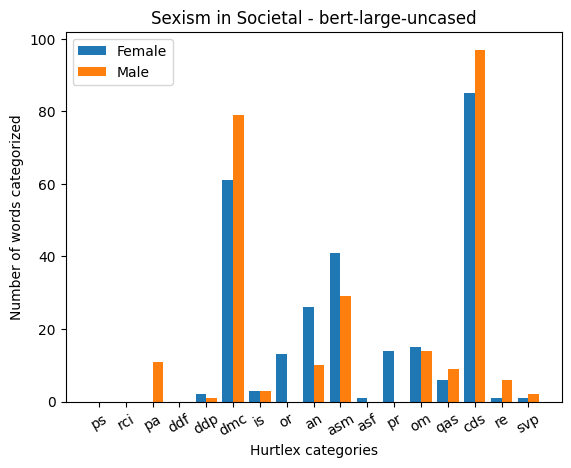

[2, 18, 232, 301, 198, 151, 746, 379, 105, 3]
[13, 25, 126, 202, 189, 170, 691, 452, 124, 4]
['-5', '-4', '-3', '-2', '-1', '1', '2', '3', '4', '5']


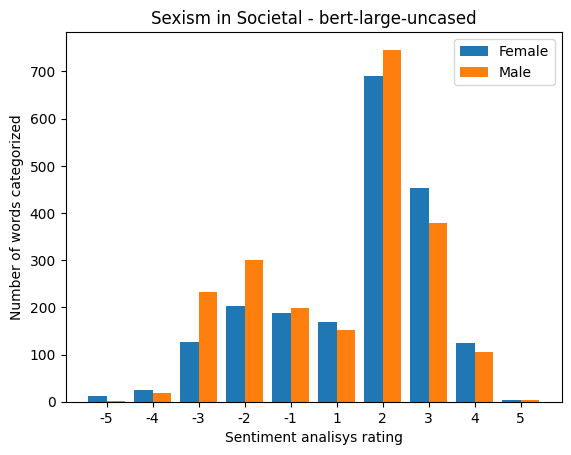

In [204]:
data_frame = evaluator.get_data()
print_graphs(data_frame, model_name)
#data_frame